# Implementation of $[[n, k, d]]$ codes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import execute, Aer, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix, Statevector, Kraus, SuperOp
from qiskit.quantum_info import hellinger_fidelity, state_fidelity
from qiskit_ibm_provider import IBMProvider, least_busy

from qiskit.result import marginal_counts
from qiskit.tools.monitor import job_monitor

In [2]:
np.random.seed(42)

#### $[[3, 1, 3]]$ bit-flip code 

Stabilizers - 

$I Z Z, Z Z I$

In [3]:
qdata_register = QuantumRegister(3, name="data")
stabilizer_measure_reg = QuantumRegister(2, name="anc")
syndrome_measure_reg = ClassicalRegister(2, name="syn")
cdata_register = ClassicalRegister(3, name="readout")

state_register = qdata_register[0]
encoding_register = qdata_register[1:]

In [4]:
def initialize_qubits(circuit: QuantumCircuit, state_reg: QuantumRegister) -> QuantumCircuit:
    ''' Initialize qubit in a particular state '''
    circuit.x(state_reg)

    circuit.barrier(state_reg)
    return circuit

def encoding(circuit: QuantumCircuit, state_reg: QuantumRegister, encoding_reg: QuantumRegister) -> QuantumCircuit:
    ''' Encoding for $$[[3, 1, 3]]$$ bit-flip code'''
    
    for reg in encoding_reg:
        circuit.cx(state_reg, reg)

    circuit.barrier(state_reg, encoding_reg)
    return circuit

def fake_noise(circuit: QuantumCircuit, qdata_reg: QuantumCircuit, distance: int, noise_type: str) -> QuantumCircuit:
    ''' Applies noise_type (either 'X' or 'Z' or 'XZ') on random 
    qubits in qdata_reg based on the distance of the code'''
    noisy_qubits = np.random.randint(len(qdata_reg), size=(distance - 1)//2)
    for qubit in noisy_qubits:
        if noise_type[0] == 'X':
            circuit.x(qdata_reg[qubit])
        if noise_type[-1] == 'Z':
            circuit.z(qdata_reg[qubit])
    return circuit

def stabilizer_measurement(circuit: QuantumCircuit, qdata_reg: QuantumRegister, stab_meas: QuantumRegister, syndrome_reg: ClassicalRegister) -> QuantumCircuit:
    ''' Measure the stabilizers using stab_meas and store the 
    error syndrome in syndrome_reg. Once the syndrome is saved, 
    reset the stab_meas qubits'''

    circuit.cx(qdata_reg[0], stab_meas[0])
    circuit.cx(qdata_reg[1], stab_meas[0])
    circuit.cx(qdata_reg[1], stab_meas[1])
    circuit.cx(qdata_reg[2], stab_meas[1])

    circuit.barrier()

    circuit.measure(stab_meas, syndrome_reg)

    # with circuit.if_test((syndrome_reg[0], 1)):
    #     circuit.x(stab_meas[0])
    # with circuit.if_test((syndrome_reg[1], 1)):
    #     circuit.x(stab_meas[1])
    
    # circuit.barrier()

    return circuit

def recovery(circuit: QuantumCircuit, qdata_reg: QuantumRegister, syndrome_reg: ClassicalRegister) -> QuantumCircuit:
    ''' Applies correction based on syndrome measurement'''
    
    with circuit.if_test((syndrome_reg, 1)):
        circuit.x(qdata_reg[0])
    with circuit.if_test((syndrome_reg, 2)):
        circuit.x(qdata_reg[2])
    with circuit.if_test((syndrome_reg, 3)):
        circuit.x(qdata_reg[1])
    
    circuit.barrier(qdata_reg)
    
    return circuit

def decoding(circuit: QuantumCircuit, state_reg: QuantumRegister, encoding_reg: QuantumRegister) -> QuantumCircuit:
    for reg in encoding_reg[::-1]:
        circuit.cx(state_reg, reg)
    
    return circuit

def final_readout(circuit: QuantumCircuit, qdata_reg: QuantumRegister, cdata_reg: ClassicalRegister) -> QuantumCircuit:
    ''' Measure qdata_reg onto cdata_reg'''
    circuit.measure(qdata_reg, cdata_reg)
    return circuit

/home/naman/Desktop/EE514_QEC/QEC project/qec_project/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


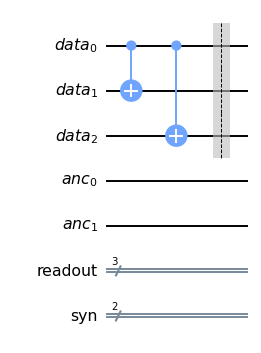

In [5]:
circuit = QuantumCircuit(qdata_register, stabilizer_measure_reg, cdata_register, syndrome_measure_reg)
circuit =  encoding(circuit, state_register, encoding_register)
# circuit = stabilizer_measurement(circuit, qdata_register, stabilizer_measure_reg, syndrome_measure_reg)
circuit.draw("mpl", scale=0.7, fold=60)

In [6]:
def build_error_correction_sequence(apply_correction = False, apply_fake_noise = None, code_distance = 3) -> QuantumCircuit:
    '''Build the error correction sequence'''
    circuit = QuantumCircuit(qdata_register, stabilizer_measure_reg, cdata_register, syndrome_measure_reg)
    circuit = initialize_qubits(circuit, qdata_register[0])

    circuit = encoding(circuit, state_register, encoding_register)
    
    if apply_fake_noise is not None:
        noise_type = apply_fake_noise
        circuit = fake_noise(circuit, qdata_register, code_distance, noise_type)

    circuit = stabilizer_measurement(circuit, qdata_register, stabilizer_measure_reg, syndrome_measure_reg)

    if apply_correction:
        circuit = recovery(circuit, qdata_register, syndrome_measure_reg)

    circuit = decoding(circuit, state_register, encoding_register)

    circuit = final_readout(circuit, qdata_register, cdata_register)

    return circuit    

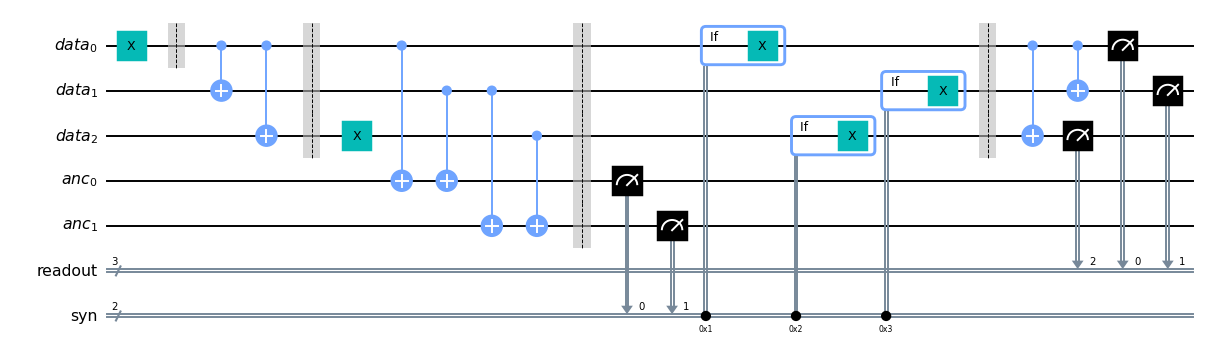

In [7]:
circuit_with_correction = build_error_correction_sequence(apply_correction = True, apply_fake_noise="X")
circuit_without_correction = build_error_correction_sequence(apply_correction = False, apply_fake_noise="X")

circuit_with_correction.draw("mpl", plot_barriers=True, scale = 0.7, fold=60)

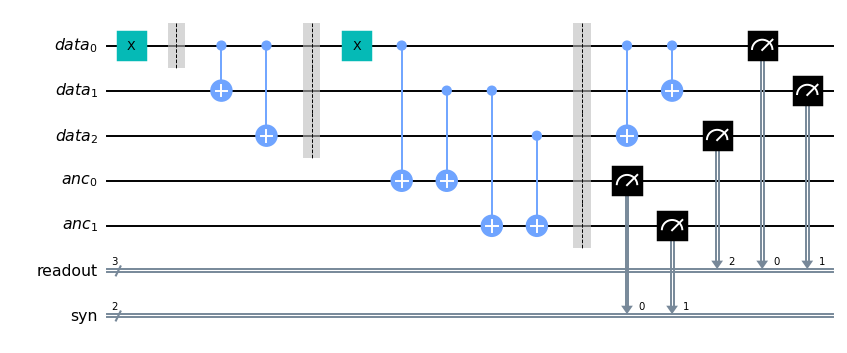

In [8]:
circuit_without_correction.draw("mpl", plot_barriers=True, scale=0.7, fold=60)

In [9]:
shots = 1024
# provider = IBMProvider()
# provider.backends()

In [10]:
# backend = least_busy(provider.backends(simulator=False, operational=True))
# backend = provider.get_backend("ibm_kyoto")
# backend

In [11]:
import qiskit_aer.noise as noise
from qiskit.providers.fake_provider import FakeMontreal

backend = FakeMontreal()
noise_model = noise.NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# p_reset = 0.03
# p_meas = 0.1
# p_gate1 = 0.05

# QuantumError objects
# error_reset = noise.pauli_error([('X', p_reset), ('I', 1 - p_reset)])
# error_meas = noise.pauli_error([('X',p_meas), ('I', 1 - p_meas)])
# error_gate1 = noise.pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
# error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
# noise_bit_flip = noise.NoiseModel()
# noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
# noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
# noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
# noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["id"])

# noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)

# backend = AerSimulator(noise_model=noise_bit_flip)
# backend = AerSimulator()

print(noise_model)
backend

NoiseModel:
  Basis gates: ['cx', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'reset', 'id', 'sx', 'cx', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), ('id', (16,)), ('id', (17,)), ('id', (18,)), ('id', (19,)), ('id', (20,)), ('id', (21,)), ('id', (22,)), ('id', (23,)), ('id', (24,)), ('id', (25,)), ('id', (26,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('sx', (7,)), ('sx', (8,)), ('sx', (9,)), ('sx', (10,)), ('sx', (11,)), ('sx', (12,)), ('sx', (13,)), ('sx', (14,)), ('sx', (15,)), ('sx', (16,)), ('sx', (17,)), ('sx', (18,)), ('sx', (19,)), ('sx', (20,)), ('sx', (21,)), ('

AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['x', 'reset', 'id', 'sx', 'cx', 'measure']>)

In [12]:
correction_transpiled_circuit = transpile(circuit_with_correction, backend)
uncorrected_transpiled_circuit = transpile(circuit_without_correction, backend)
# correction_transpiled_circuit.draw(output="mpl", idle_wires=False, scale=0.5, fold=50)

In [13]:
job_with_correction = backend.run(correction_transpiled_circuit, shots=shots, dynamic=True)
job_monitor(job_with_correction)

Job Status: job has successfully run


In [14]:
# import json
# from qiskit.result import Result

# f = open('./3_1_3_bit_flip/cnx8d2wsdyyg0080kegg-result.txt')
# correction_data = json.load(f)

# result_with_correction = Result.from_dict(correction_data)

In [15]:
# result_with_correction.get_counts()

In [16]:
result_with_correction = job_with_correction.result()

In [17]:
job_without_correction = backend.run(uncorrected_transpiled_circuit, shots=shots, dynamic = True)
job_monitor(job_without_correction)

Job Status: job has successfully run


In [18]:
result_without_correction = job_without_correction.result()

In [19]:
initial_state = ['001']
ideal_result = {'001': shots}

In [20]:
data_indices = list(range(len(qdata_register)))
syndrome_indices = list(range(data_indices[-1]+1, len(qdata_register) + len(syndrome_measure_reg) ))

def decode_result(data_counts, syndrome_counts, initial_state):
    shots = sum(data_counts.values())
    success_trials = sum([data_counts.get(i, 0) for i in initial_state])
    failed_trials = shots - success_trials
    error_correction_events = shots - syndrome_counts.get('00', 0)
    print(f"Bit flip errors were detected/corrected on {error_correction_events}/{shots} trials")
    print(f"A final parity error was detected on {failed_trials}/{shots} trials")

In [21]:
print("******************** Without Quantum Error Correction ********************\n")

non_corrected_marginalized_data_counts = marginal_counts(result_without_correction, data_indices).get_counts(0)
non_corrected_marginalized_syndrome_counts = marginal_counts(result_without_correction, syndrome_indices).get_counts(0)

print(f'Completed bit code experiment data measurement counts {non_corrected_marginalized_data_counts}')
print(f'Completed bit code experiment syndrome measurement counts {non_corrected_marginalized_syndrome_counts}')
decode_result(non_corrected_marginalized_data_counts, non_corrected_marginalized_syndrome_counts, initial_state)

print("\nFidelity: {}".format(hellinger_fidelity(ideal_result, non_corrected_marginalized_data_counts)))

******************** Without Quantum Error Correction ********************

Completed bit code experiment data measurement counts {'100': 87, '101': 2, '110': 915, '111': 3, '010': 16, '000': 1}
Completed bit code experiment syndrome measurement counts {'00': 7, '10': 4, '11': 10, '01': 1003}
Bit flip errors were detected/corrected on 1017/1024 trials
A final parity error was detected on 1024/1024 trials

Fidelity: 0.0


In [22]:
print("******************** With Quantum Error Correction ********************\n")

corrected_marginalized_data_counts = marginal_counts(result_with_correction, data_indices).get_counts(0)
corrected_marginalized_syndrome_counts = marginal_counts(result_with_correction, syndrome_indices).get_counts(0)

print(f'Completed bit code experiment data measurement counts {corrected_marginalized_data_counts}')
print(f'Completed bit code experiment syndrome measurement counts {corrected_marginalized_syndrome_counts}')
decode_result(corrected_marginalized_data_counts, corrected_marginalized_syndrome_counts, initial_state)

print("\nFidelity: {}".format(hellinger_fidelity(ideal_result, corrected_marginalized_data_counts)))

******************** With Quantum Error Correction ********************

Completed bit code experiment data measurement counts {'011': 53, '010': 5, '111': 13, '000': 21, '001': 896, '101': 36}
Completed bit code experiment syndrome measurement counts {'10': 978, '01': 10, '11': 14, '00': 22}
Bit flip errors were detected/corrected on 1002/1024 trials
A final parity error was detected on 128/1024 trials

Fidelity: 0.875
